In [22]:
import pandas as pd
from scipy import sparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.tokenize import wordpunct_tokenize
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import re
import string

### Inserting fake and real dataset

In [23]:
news_dataset = pd.read_csv("train.csv") 
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data Cleaning
### Missing values

In [24]:
## Checking for missing values
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

The number of missing values of text and title are relatively low. So these instances can be removed. The number of missing values of the author column are more than that of the columns title and text. ALthough they are still relatively low, so they can be filled in with the most common. 

In [25]:
news_dataset['author'].value_counts()

Pam Key                                                                                                                                                          243
admin                                                                                                                                                            193
Jerome Hudson                                                                                                                                                    166
Charlie Spiering                                                                                                                                                 141
John Hayward                                                                                                                                                     140
                                                                                                                                                                ... 
Understand

In [26]:
news_dataset['author'] = news_dataset['author'].fillna("Pam Key")

In [27]:
news_dataset.isnull().sum()

id          0
title     558
author      0
text       39
label       0
dtype: int64

In [28]:
news_dataset = news_dataset.dropna()

### Detecting outliers

C:\Users\gebruiker\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label'>

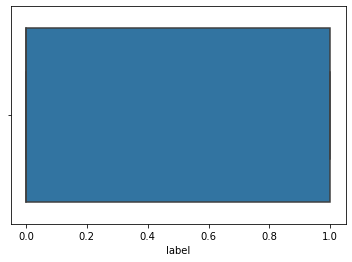

In [29]:
# Label are the only numerical values(main feature), so we check if it contains outliers.
sns.boxplot(news_dataset['label'])

It does not contain any outliers.

## Preprocessed Text

In [30]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') 
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)   
    return lemmatizer.lemmatize(text)

In [32]:
news_dataset["title"] = news_dataset["title"].fillna('')
news_dataset["author"] = news_dataset["author"].fillna('')
news_dataset["text"] = news_dataset["text"].fillna('')

news_dataset["article"] = news_dataset["title"] + " " + news_dataset["author"] + " " + news_dataset["text"]
news_dataset["article"] = news_dataset["article"].apply(preprocess)

In [33]:
# text word count
news_dataset['word_count'] = news_dataset['article'].apply(lambda x: len(str(x).split()))
print(news_dataset[news_dataset['label']==1]['word_count'].mean()) # fake articles
print(news_dataset[news_dataset['label']==0]['word_count'].mean()) # reliable articles

690.0372860635697
871.5522287474728


<AxesSubplot:>

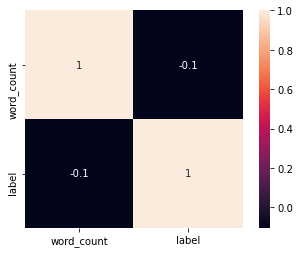

In [34]:
cols = ['word_count', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

In [35]:
news_dataset['Avg_length'] = news_dataset["article"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
print(news_dataset[news_dataset['label'] == 1]['Avg_length'].mean())
print(news_dataset[news_dataset['label'] == 0]['Avg_length'].mean())

4.849775509599386
4.764370868666601


<AxesSubplot:>

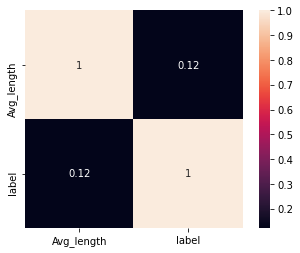

In [36]:
cols = ['Avg_length', 'label']
corrmat = news_dataset[cols].corr()
sns.heatmap(corrmat, square=True, annot=True)

## Training

In [37]:
word_count_avg_length = news_dataset[["word_count", "Avg_length"]].values 
article = news_dataset["article"].values
labels = news_dataset['label'].values

In [38]:
models = {}

#### Splitting the dataset into training set and testing set. 

In [39]:
train_info, test_info,  train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

In [40]:
vectorization = TfidfVectorizer()
train_article = vectorization.fit_transform(train_article)
test_article = vectorization.transform(test_article)

In [41]:
train_data = sparse.hstack([train_article, train_info])
test_data = sparse.hstack([test_article, test_info])

### 1. Logistic Regression

In [42]:
LR = LogisticRegression()
LR.fit(train_data, train_labels)

C:\Users\gebruiker\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
predictionLr = LR.predict(test_data)

In [44]:
LR.score(test_data, test_labels)

0.9406087602078693

In [45]:
models[LR] = LR.score(test_data, test_labels)

In [46]:
print(classification_report(test_labels, predictionLr))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2116
           1       0.94      0.94      0.94      1925

    accuracy                           0.94      4041
   macro avg       0.94      0.94      0.94      4041
weighted avg       0.94      0.94      0.94      4041



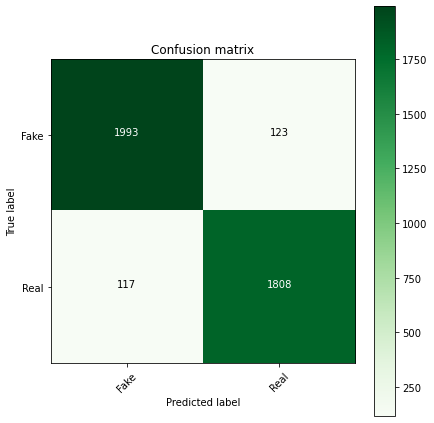

In [47]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionLr)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [48]:
testdata = pd.read_csv('test.csv')
 
testdata = testdata.fillna('') 

testdata["article"] = testdata["title"] + " " + testdata["author"] + " " + testdata["text"]
testdata['article'] = testdata['article'].apply(preprocess) 

testdata['word_count'] = testdata['article'].apply(lambda x: len(str(x).split()))
testdata['Avg_length'] = testdata["article"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

wordCount_avgLength = testdata[["word_count", "Avg_length"]].values

testdatavalues = testdata['article'].values  
testdatavalues = vectorization.transform(testdatavalues)

newcontent = sparse.hstack([testdatavalues, wordCount_avgLength])
testdata['label'] = LR.predict(newcontent)

newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,1
5196,25996,0
5197,25997,0
5198,25998,1


### 2. Decision Tree Classification

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
DT = DecisionTreeClassifier()
DT.fit(train_data, train_labels)

DecisionTreeClassifier()

In [51]:
predictionDT = DT.predict(test_data)

In [52]:
DT.score(test_data, test_labels)

0.96362286562732

In [53]:
models[DT] = DT.score(test_data, test_labels)

In [54]:
print(classification_report(test_labels, predictionDT))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2116
           1       0.96      0.96      0.96      1925

    accuracy                           0.96      4041
   macro avg       0.96      0.96      0.96      4041
weighted avg       0.96      0.96      0.96      4041



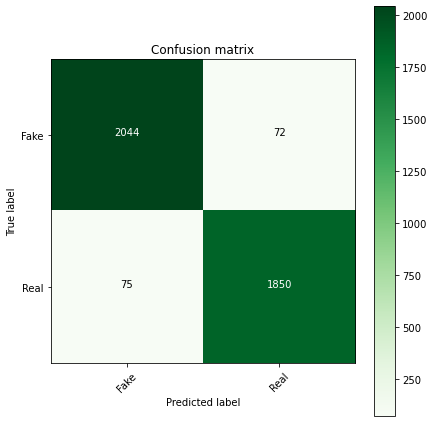

In [55]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionDT)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Testing on test data

In [56]:
testdata = pd.read_csv('test.csv')
 
testdata = testdata.fillna('') 

testdata["article"] = testdata["title"] + " " + testdata["author"] + " " + testdata["text"]
testdata['article'] = testdata['article'].apply(preprocess) 

testdata['word_count'] = testdata['article'].apply(lambda x: len(str(x).split()))
testdata['Avg_length'] = testdata["article"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

wordCount_avgLength = testdata[["word_count", "Avg_length"]].values

testdatavalues = testdata['article'].values  
testdatavalues = vectorization.transform(testdatavalues)

newcontent = sparse.hstack([testdatavalues, wordCount_avgLength])
testdata['label'] = DT.predict(newcontent)

newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1
